 # scRNA-seq Jupyter Notebook for TERVA - mouse generic tissue quality control by condition 
 
 The following Jupyter Notebook decribes a pipeline for the analysis of a generic sample (tissue), taking as input the matrices of different conditions found in the sample.

###  Load required packages
If the packages are not found, install them via pip or via conda

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

import anndata as ad
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sb
import scvelo as scv
import re
from rpy2.robjects import pandas2ri

import rpy2.rinterface_lib.callbacks
import rpy2
%load_ext rpy2.ipython

import time # for the sleep function
import os # to iterate over directories

In [2]:
# A nice color scheme for visualizing gene expression
colors_2 = plt.cm.OrRd(np.linspace(0.05, 1, 128))
colors_3 = plt.cm.Greys_r(np.linspace(0.8,0.9,20))
colors_Comb = np.vstack([colors_3, colors_2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colors_Comb)

In [3]:
# scanpy settings
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)

In [4]:
##print package version list
#sc.logging.print_versions()

### Variable inputs
The pipeline orders and filters the results based on several parameters. Adapt these parameters for your particular application.

In [5]:
# Variables for reading in data:
tissue = 'WA' # name of the sample; change accordingly 

conditionnames = ['C','ED','LD','PL','IC'] # name of the conditions in the preferred (arbitrary) order of display; change accordingly
# note that the paths for reading in data will be:
    # 10x matrix:    cellranger_outputs/'+ tissue +'/' + conditionnames[n] + '-' + tissue + '_primirs' + '/outs'
    # HTO data:      hto_classification/'+ tissue +'/' + conditionnames[file]+'-' + tissue + '_HTO_info.txt'
conditionlength = len(conditionnames)

In [6]:
# Variables for filtering
filter_genes = 3 # genes expressed in less than (filter_genes) cells will be removed

if (tissue == "AO"):
    max_n_counts=[6000,1800,10000,4000,3000]
    max_mito=[0.15,0.08,0.15,0.15,0.15]
    min_n_genes=[400,200,350,450,450] 
elif (tissue == "MO"): 
    max_n_counts=[7000,8000,6000,8000,8000]
    max_mito=[0.08,0.08,0.1,0.1,0.1]
    min_n_genes=[550,550,450,520,520]
elif (tissue == "WA"):
    max_n_counts=[15000,18000,18000,15000,14000]
    max_mito=[0.1,0.08,0.08,0.1,0.1]
    min_n_genes=[550,550,500,550,550]
else:
    print("Unknown tissue")
# Assumes conditionlength == 5; provide aditional or less parameters as needed

In [7]:
# Variables for data storage
filtered_file = 'outputs/' + tissue + '/terva_'+ tissue + '_qc_DSB.h5ad' # path for the output anndata object

# 1. Read in data

In [8]:
adata = [sc.read_10x_mtx('cellranger_outputs/'+ tissue +'/' + conditionnames[file] + '-' + tissue + '_primirs' + '/outs', var_names='gene_symbols', cache=True) for file in list(range(0,conditionlength))]

for file in list(range(0, conditionlength)):
    print(conditionnames[file])
    adata[file].obs['ConditionID'] = file + 1
    adata[file].obs['ConditionName'] = conditionnames[file]
    adata[file].var_names_make_unique()
    adata[file].obs['Tissue'] = tissue
    adata[file].obs['celltype_pred_0']='blank'
    adata[file].obs['HTO_classification']='blank'
    adata[file].obs['HTO_classification_global']='blank'
    print('Cells found both in the 10x matrix: ', len(adata[file]))
    
    #HTO classification read and create annotation lists
    print('hto_classification/'+ tissue +'/' + conditionnames[file]+'-' + tissue + '_HTO_info_DSB.txt')
    with open('hto_classification/'+ tissue +'/' + conditionnames[file]+'-' + tissue + '_primirs_HTO_info_DSB.txt', 'r') as hto_file:
        lines = hto_file.readlines()
        hto_class = []
        hto_global = []
        hto_name = []
        celltype_pred = []
    for l in lines[1:]:
        l_list = l.split("	")
        hto_name.append(l_list[0])
        celltype_pred.append(l_list[4])
        hto_class.append(l_list[5]) #remember to check which line is global classification in your file
        hto_global.append(l_list[6]) #use l_list[11].rstrip('\n') if needed to remove newline marks (e.g. anti-mouse-Hashtag-5\n -> anti-mouse-Hashtag-5)
                
    # Adding HTO classification to adata
    # Note that not all 10x cells are in HTO classification, and vice versa
    # If the adata cell entry has an equivalent in the HTO file, HTO values are added
    # If there is no corresponding entry in the HTO file, HTO values are set to 'none'
    print('Cells found both in the HTO file: ', len(hto_class))
    intersection = [name for name in adata[file].obs_names if name in hto_name]
    print('Cells found both in HTO file and 10x matrix: ', len(intersection))
    for cell in range(0,len(adata[file].obs_names)):
        if adata[file].obs_names[cell] in hto_name:
            index = hto_name.index(adata[file].obs_names[cell])
            adata[file].obs['celltype_pred_0'][cell] = celltype_pred[index]
            adata[file].obs['HTO_classification'][cell] = hto_class[index]
            adata[file].obs['HTO_classification_global'][cell] = hto_global[index]

        else: 
            adata[file].obs['celltype_pred_0'][cell] = 'none'
            adata[file].obs['HTO_classification'][cell] = 'none'
            adata[file].obs['HTO_classification_global'][cell] = 'none'

... reading from cache file cache/cellranger_outputs-WA-C-WA_primirs-outs-matrix.h5ad
... reading from cache file cache/cellranger_outputs-WA-ED-WA_primirs-outs-matrix.h5ad
... reading from cache file cache/cellranger_outputs-WA-LD-WA_primirs-outs-matrix.h5ad
... reading from cache file cache/cellranger_outputs-WA-PL-WA_primirs-outs-matrix.h5ad
... reading from cache file cache/cellranger_outputs-WA-IC-WA_primirs-outs-matrix.h5ad


C
Cells found both in the 10x matrix:  6307
hto_classification/WA/C-WA_HTO_info_DSB.txt
Cells found both in the HTO file:  5954
Cells found both in HTO file and 10x matrix:  5954
ED
Cells found both in the 10x matrix:  7110
hto_classification/WA/ED-WA_HTO_info_DSB.txt
Cells found both in the HTO file:  6649
Cells found both in HTO file and 10x matrix:  6649
LD
Cells found both in the 10x matrix:  7800
hto_classification/WA/LD-WA_HTO_info_DSB.txt
Cells found both in the HTO file:  7438
Cells found both in HTO file and 10x matrix:  7438
PL
Cells found both in the 10x matrix:  7436
hto_classification/WA/PL-WA_HTO_info_DSB.txt
Cells found both in the HTO file:  7135
Cells found both in HTO file and 10x matrix:  7135
IC
Cells found both in the 10x matrix:  6696
hto_classification/WA/IC-WA_HTO_info_DSB.txt
Cells found both in the HTO file:  6007
Cells found both in HTO file and 10x matrix:  6007


In [9]:
adata[0].obs.head()

,ConditionID,ConditionName,Tissue,celltype_pred_0,HTO_classification,HTO_classification_global
AAACCTGAGACCTAGG-1,1,C,WA,,Negative,Negative
AAACCTGAGCGTTTAC-1,1,C,WA,,anti-mouse-Hashtag-6,Singlet
AAACCTGAGTGTACGG-1,1,C,WA,,anti-mouse-Hashtag-4,Singlet
AAACCTGCAAAGTCAA-1,1,C,WA,,Negative,Negative
AAACCTGCAAGTAATG-1,1,C,WA,,anti-mouse-Hashtag-6,Singlet


In [10]:
adata[0].var.head()

,gene_ids,feature_types
Xkr4,ENSMUSG00000051951,Gene Expression
Gm1992,ENSMUSG00000089699,Gene Expression
Gm37381,ENSMUSG00000102343,Gene Expression
Rp1,ENSMUSG00000025900,Gene Expression
Sox17,ENSMUSG00000025902,Gene Expression


# 2. Preprocessing

## 2.1 HTO classification
Removing doublets and cells with "none" HTO value and renaming classification values

In [11]:
# filtering out cells with 'HTO_classification' == 'none' and 'HTO_classification' == 'Doublet'
# cells with 'HTO_classification' == 'none' are cells which were found in the 10x matrix but did not have any corresponnding HTO data (see read in data step)
for file in list(range(0, conditionlength)):
    print ('----- condition: ', conditionnames[file], ' -----')
    adata[file] = adata[file][adata[file].obs['HTO_classification_global'] != 'Doublet', :]
    print('Cells after doublet filter: ', len(adata[file]))
    #Lines for removing Negative and "none" values (if desired; omitted in this analysis)
    #print('Initial amount of cells:    ', len(adata[file]))
    #adata[file] = adata[file][adata[file].obs['HTO_classification_global'] != 'none', :]
    #print('Cells after none filter:    ', len(adata[file]))
    #adata[file] = adata[file][adata[file].obs['HTO_classification_global'] != 'Negative', :]
    #print('Cells after negative filter:    ', len(adata[file]))
    time.sleep(1) # added to prevent Jupyter Lab from mixing up prints

----- condition:  C  -----
Cells after doublet filter:  6082
----- condition:  ED  -----
Cells after doublet filter:  6702
----- condition:  LD  -----
Cells after doublet filter:  7146
----- condition:  PL  -----
Cells after doublet filter:  7170
----- condition:  IC  -----
Cells after doublet filter:  6230


In [12]:
# renaming HTO values
for file in list(range(0, conditionlength)): 
    adata[file].obs["HTO_classification"]=[re.sub('anti-mouse-Hashtag-','',x) for x in adata[file].obs["HTO_classification"]]
    adata[file].obs["HTO_classification"]=[re.sub('Negative','N',x) for x in adata[file].obs["HTO_classification"]]

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [13]:
adata[0].obs.head()

,ConditionID,ConditionName,Tissue,celltype_pred_0,HTO_classification,HTO_classification_global
AAACCTGAGACCTAGG-1,1,C,WA,,N,Negative
AAACCTGAGCGTTTAC-1,1,C,WA,,6,Singlet
AAACCTGAGTGTACGG-1,1,C,WA,,4,Singlet
AAACCTGCAAAGTCAA-1,1,C,WA,,N,Negative
AAACCTGCAAGTAATG-1,1,C,WA,,6,Singlet


## 2.2 Normalization & filtering

In [14]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
for file in list(range(0, conditionlength)):
    adata[file].raw = sc.pp.log1p(adata[file], copy=True)

Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


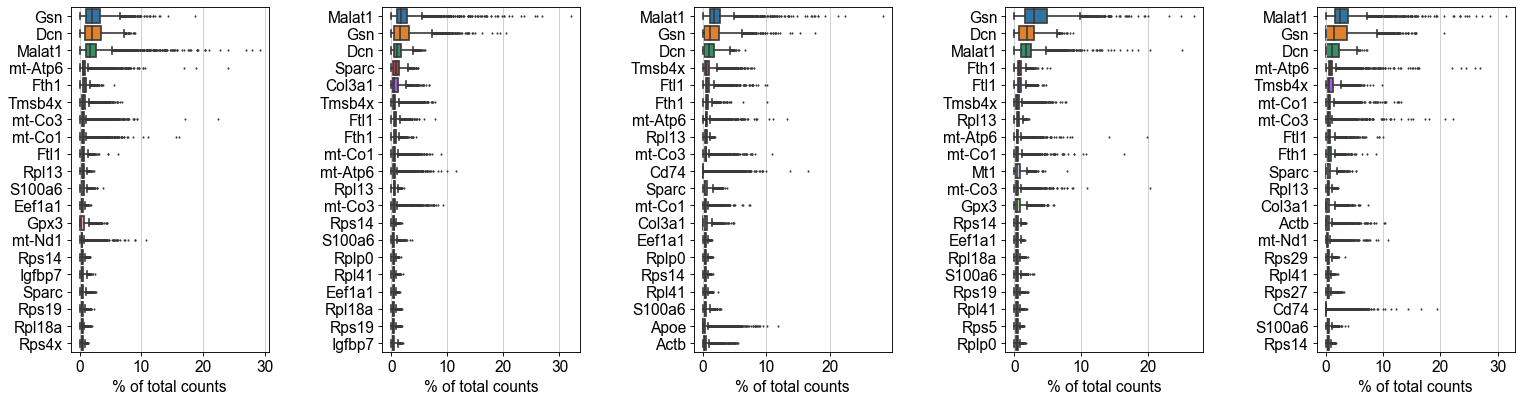

In [15]:
fig,ax = plt.subplots(1,5, figsize=(20,6))
for file in list(range(0, conditionlength)):
    sc.pl.highest_expr_genes(adata[file], n_top=20, ax=ax[file],show=False) 
plt.tight_layout(pad=3.0)
plt.show()
## this looks normal, repeat this plot after filtering

In [16]:
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)

for file in list(range(0, conditionlength)):
    mito_genes = [name for name in adata[file].var_names if name.startswith('Mt-') or name.startswith('mt-')] ## watch out 
    adata[file].obs['percent_mito'] = np.sum(adata[file][:, mito_genes].X, axis=1).A1 / np.sum(adata[file].X, axis=1).A1

# same could be done for example ribosomal genes
#ribo_genes = adata.var_names.str.startswith('Rp')

    ribo_genes = [name for name in adata[file].var_names if name.startswith('Rp')]
    adata[file].obs['percent_ribo'] = np.sum(adata[file][:, ribo_genes].X, axis=1).A1 / np.sum(adata[file].X, axis=1).A1

# add the total counts per cell as observations-annotation to adata

    adata[file].obs['n_counts'] = adata[file].X.sum(axis=1).A1
    adata[file].obs['log_counts'] = np.log(adata[file].obs['n_counts'])
    adata[file].obs['n_genes'] = (adata[file].X > 0).sum(1)

### 2.2.1 Plots for filtering decisions
These plots are just an aid for setting the actual filtering parameters (set in one of the first cells of this notebook for convenience)

... storing 'ConditionName' as categorical
... storing 'Tissue' as categorical
... storing 'celltype_pred_0' as categorical
... storing 'HTO_classification' as categorical
... storing 'HTO_classification_global' as categorical
... storing 'feature_types' as categorical
... storing 'ConditionName' as categorical
... storing 'Tissue' as categorical
... storing 'celltype_pred_0' as categorical
... storing 'HTO_classification' as categorical
... storing 'HTO_classification_global' as categorical
... storing 'feature_types' as categorical
... storing 'ConditionName' as categorical
... storing 'Tissue' as categorical
... storing 'celltype_pred_0' as categorical
... storing 'HTO_classification' as categorical
... storing 'HTO_classification_global' as categorical
... storing 'feature_types' as categorical
... storing 'ConditionName' as categorical
... storing 'Tissue' as categorical
... storing 'celltype_pred_0' as categorical
... storing 'HTO_classification' as categorical
... storing 'HTO_c

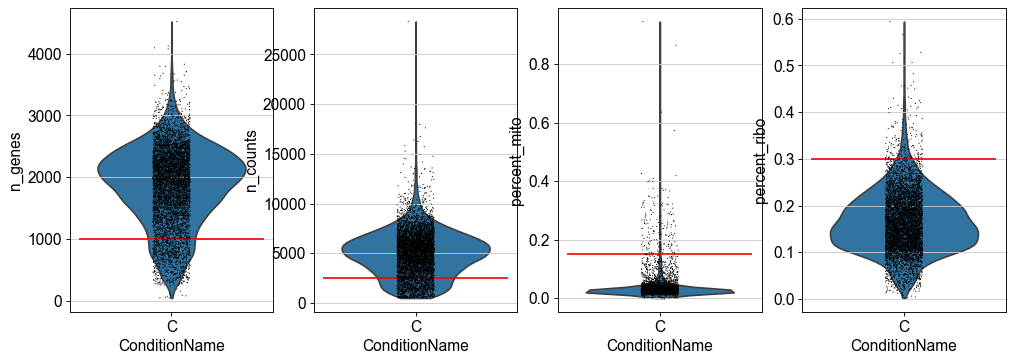

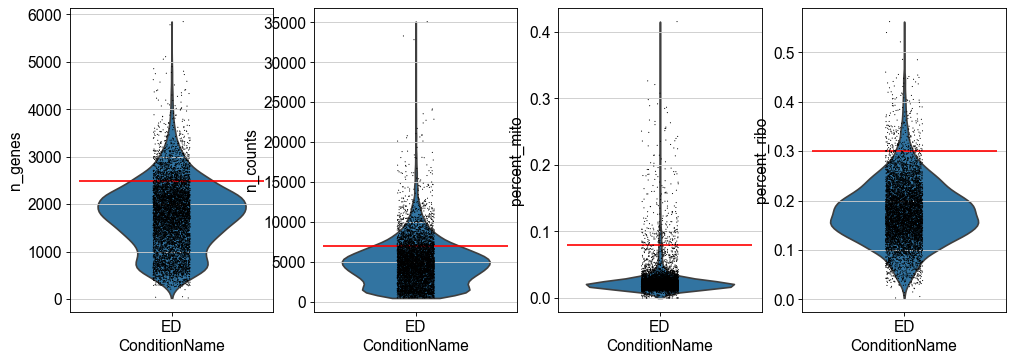

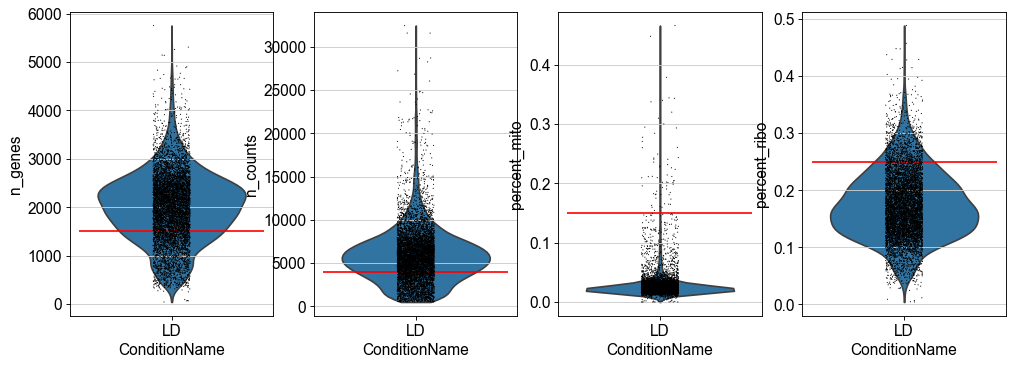

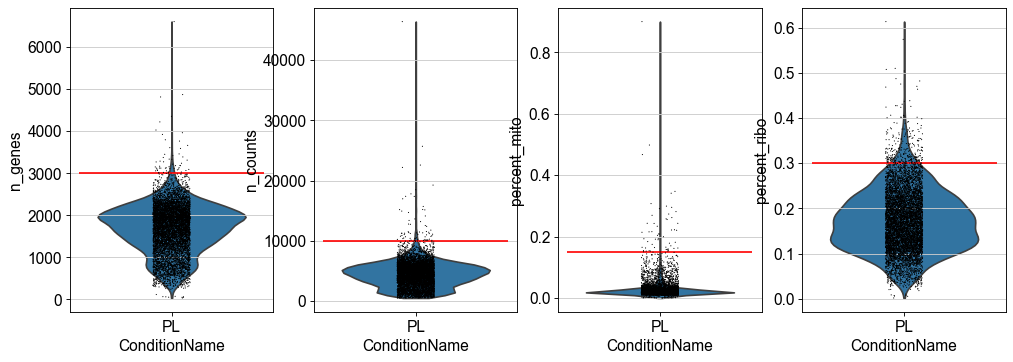

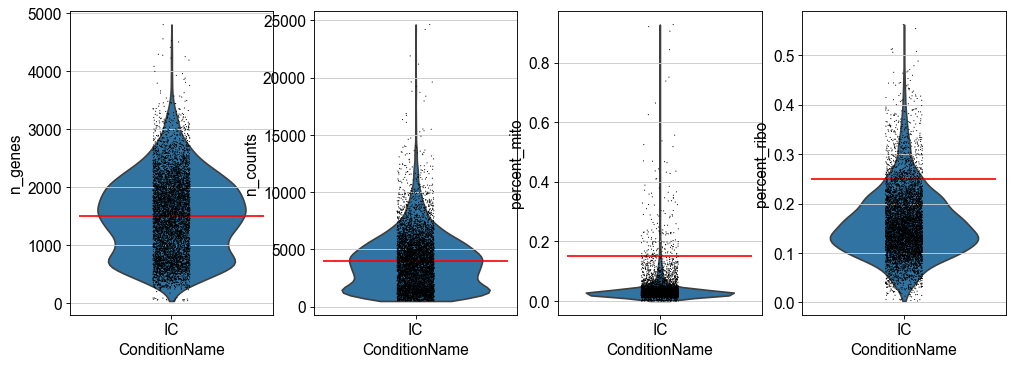

In [17]:
lim_n_genes =[0,0,0,0,0]
lim_n_counts =[0,0,0,0,0]
lim_percent_mito =[0,0,0,0,0]
lim_percent_ribo =[0,0,0,0,0]

for file in list(range(0, conditionlength)):
    fig,ax = plt.subplots(1,4, figsize=(15,5))
    v1 = sc.pl.violin(adata[file], ['n_genes'], groupby ="ConditionName", ax=ax[0],show=False)
                  #    ,save="violin_plots_wo_filtering_ngenes_07012021.png")
    x, y = v1.get_xlim()
    v1.hlines(lim_n_genes[file], x, y, colors='red')

    
    v2 = sc.pl.violin(adata[file], ['n_counts'],  groupby ="ConditionName", ax=ax[1],show=False)
                 #,save="violin_plots_wo_filtering_ncounts_07012021.png")
    x, y = v2.get_xlim()
    v2.hlines(lim_n_counts[file], x, y, colors='red')


    v3 = sc.pl.violin(adata[file], ['percent_mito'],  groupby ="ConditionName", ax=ax[2],show=False)
                      #,save="violin_plots_wo_filtering_pctmito_07012021.png")
    x, y = v3.get_xlim()
    v3.hlines(lim_percent_mito[file], x, y, colors='red')


    v4 = sc.pl.violin(adata[file], ['percent_ribo'],  groupby ="ConditionName", ax=ax[3],show=False)
                      
    x, y = v4.get_xlim()
    v4.hlines(lim_percent_ribo[file], x, y, colors='red')

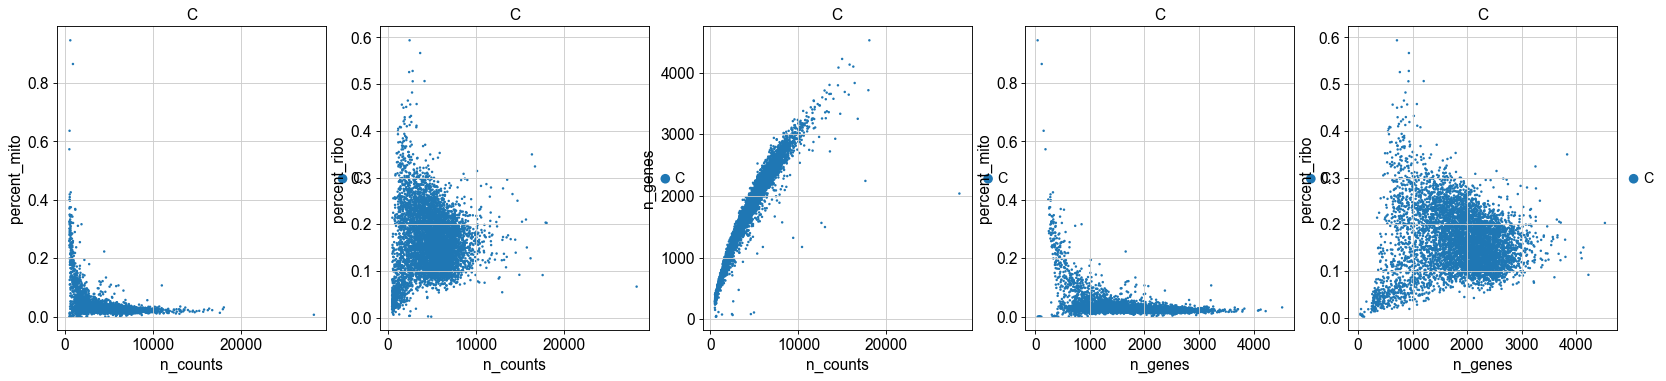

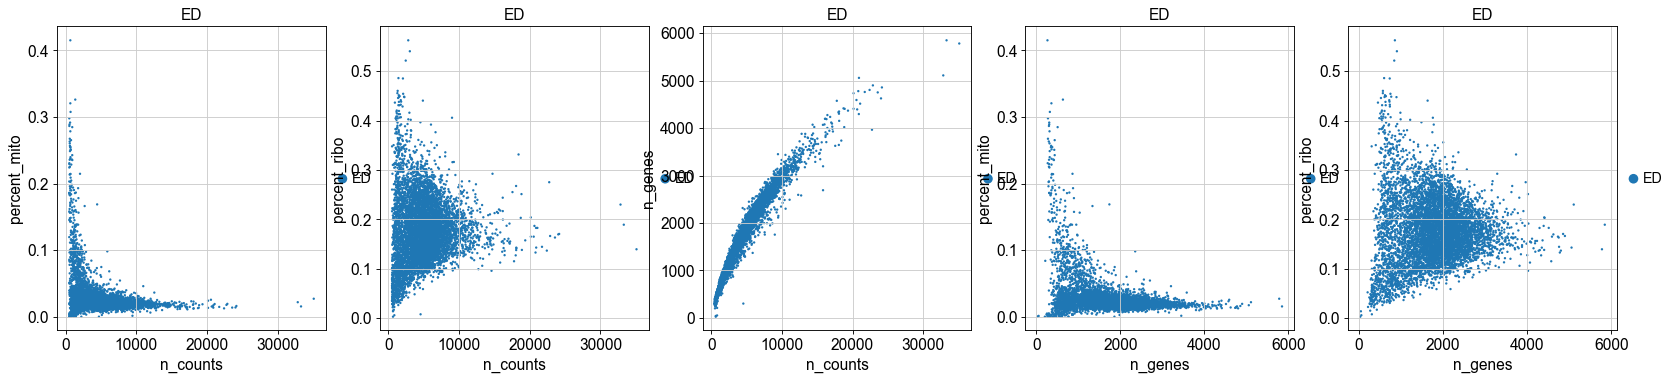

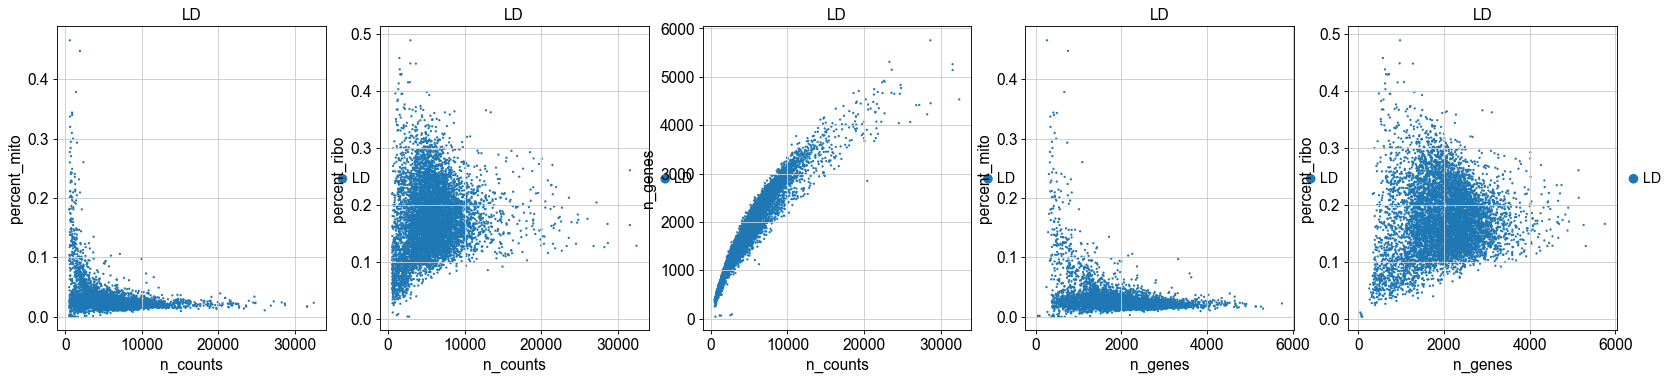

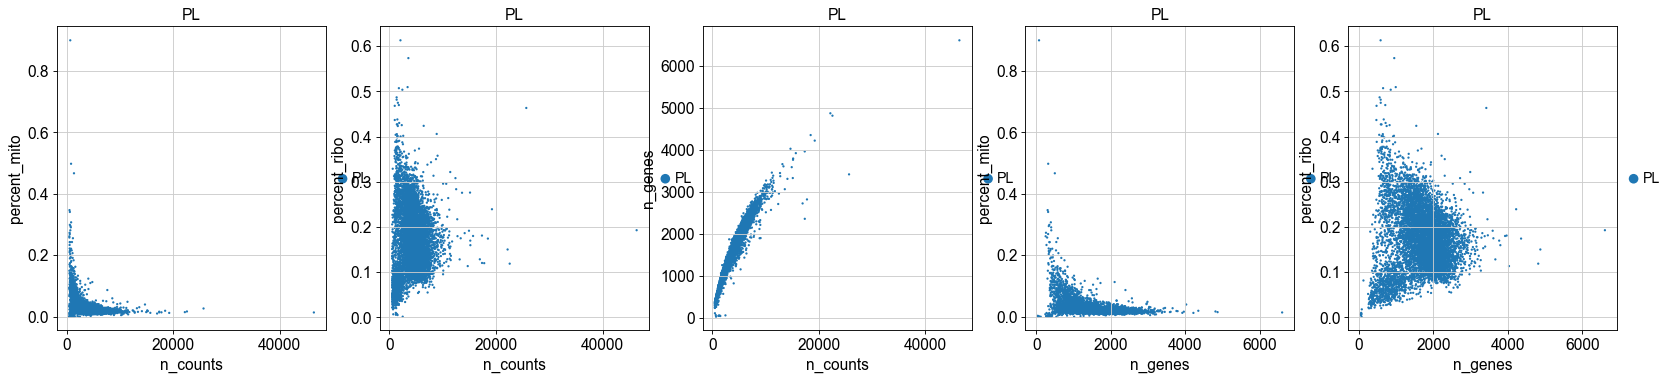

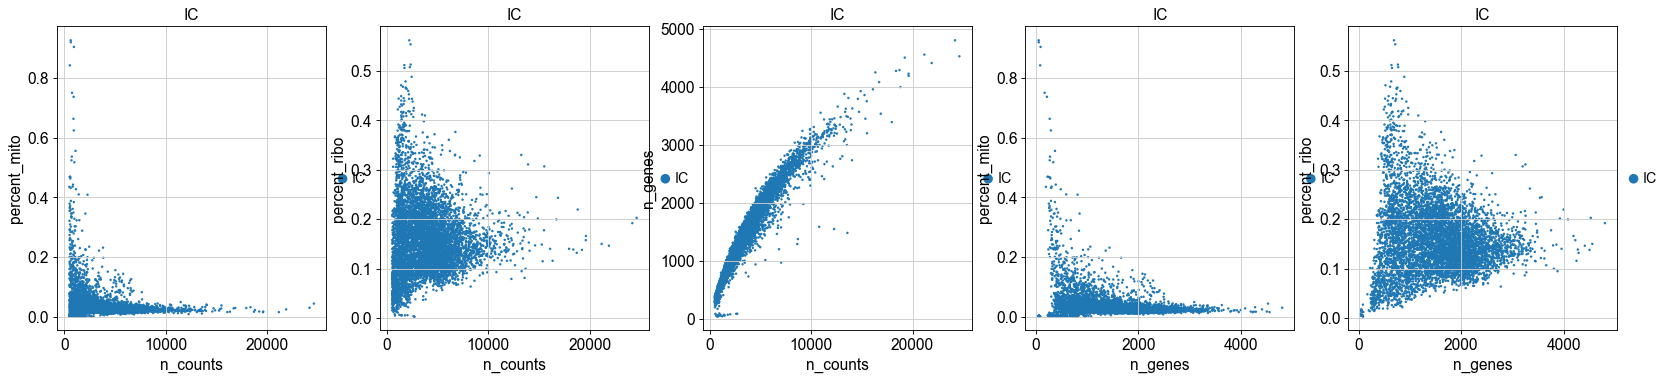

In [18]:
## alternative plots for filtering
for file in list(range(0, conditionlength)):
    fig,ax = plt.subplots(1,5, figsize=(25,5))
    sc.pl.scatter(adata[file], x='n_counts', y='percent_mito', color ="ConditionName",ax=ax[0],show=False, title=conditionnames[file])
    sc.pl.scatter(adata[file], x='n_counts', y='percent_ribo', color ="ConditionName",ax=ax[1],show=False, title=conditionnames[file])
    sc.pl.scatter(adata[file], x='n_counts', y='n_genes', color ="ConditionName",ax=ax[2],show=False, title=conditionnames[file])
    sc.pl.scatter(adata[file], x='n_genes', y='percent_mito', color ="ConditionName",ax=ax[3],show=False, title=conditionnames[file])
    sc.pl.scatter(adata[file], x='n_genes', y='percent_ribo', color ="ConditionName",ax=ax[4],show=False, title=conditionnames[file])

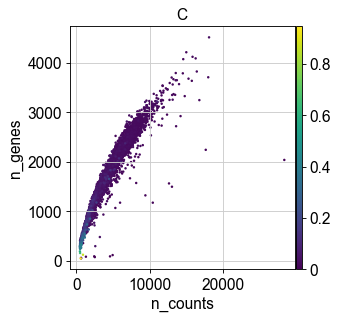

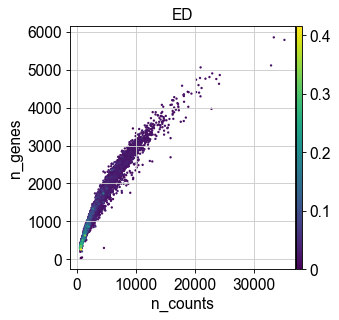

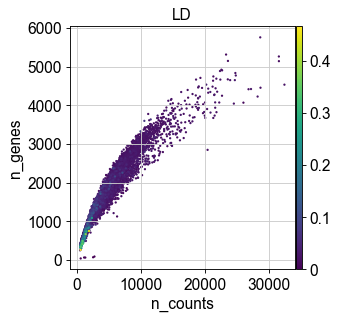

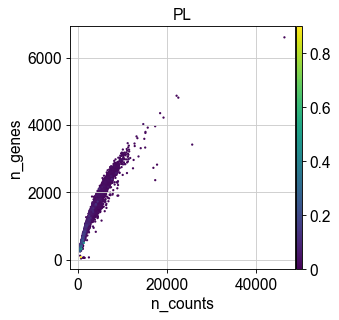

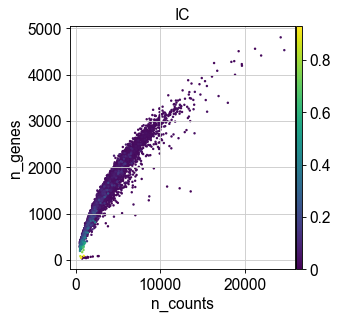

In [19]:
#Data quality summary plots
for file in list(range(0, conditionlength)):
    sc.pl.scatter(adata[file], x='n_counts', y='n_genes', color ="percent_mito", title=conditionnames[file])

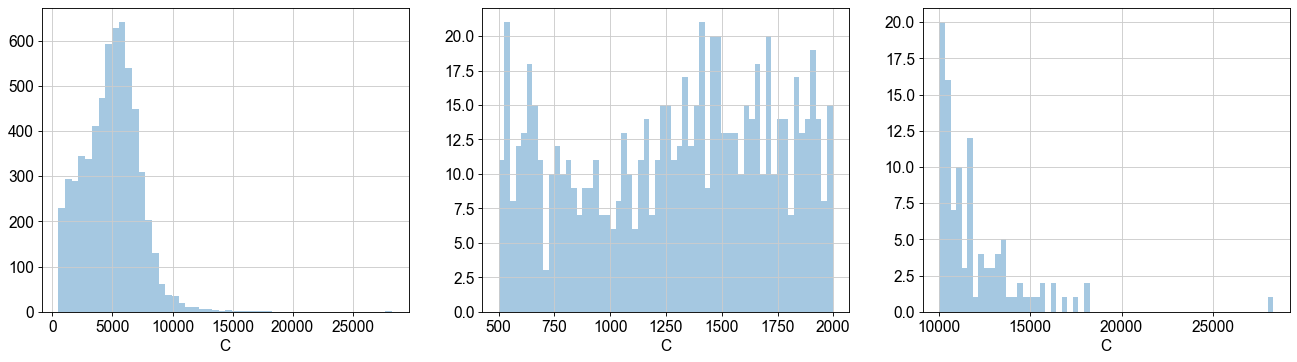

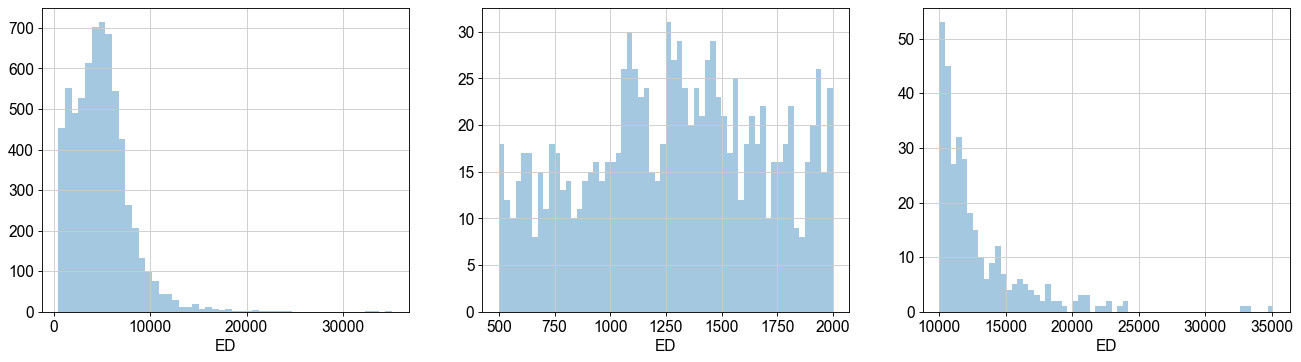

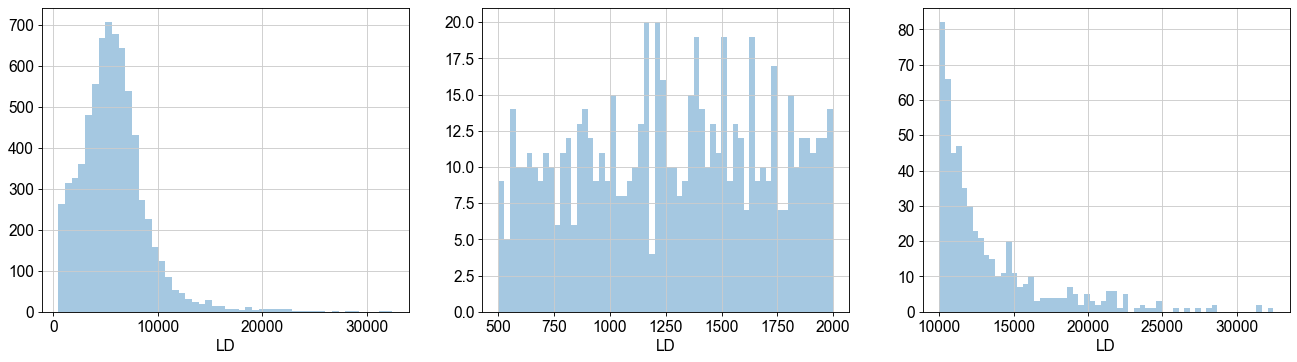

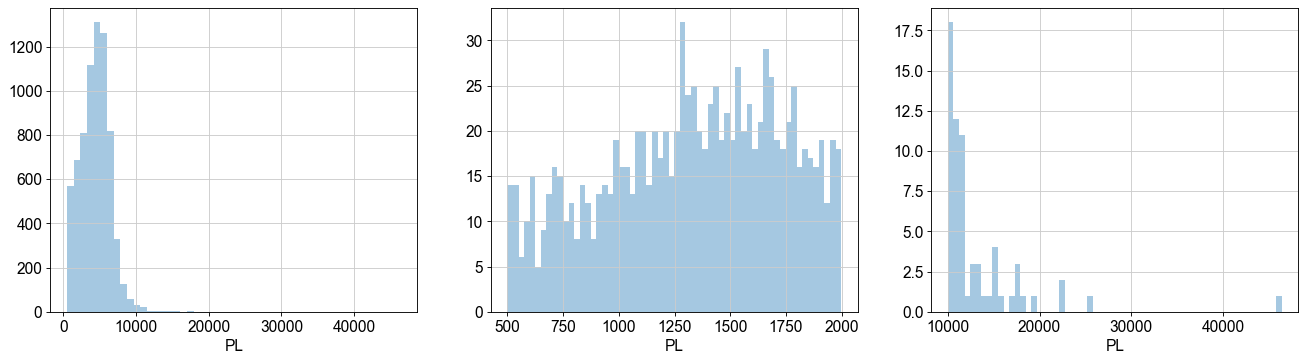

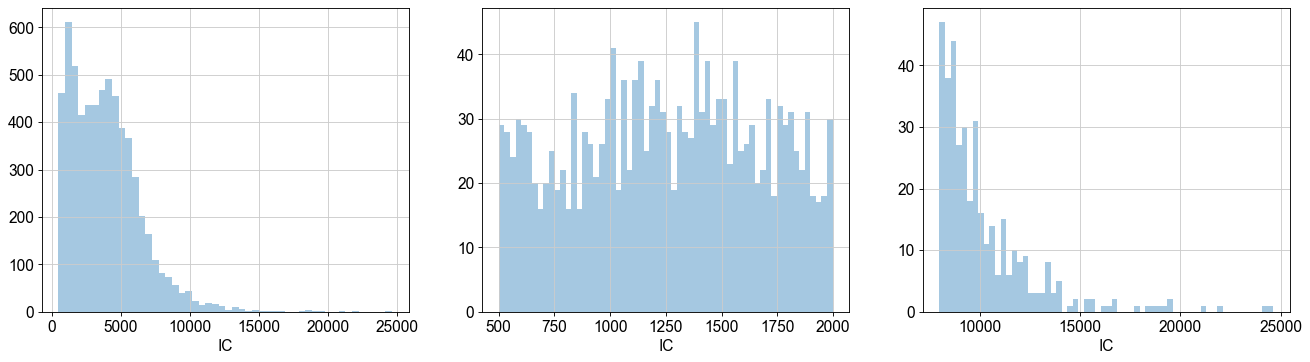

In [20]:
#Thresholding decision: counts
thr_n_counts_l=[2000,2000,2000,2000,2000] #lowpass filter
thr_n_counts_p=[10000,10000,10000,10000,8000] #highpass filter
for file in list(range(0, conditionlength)):
    fig,ax = plt.subplots(1,3, figsize=(20,5))
    p3 = sb.distplot(adata[file].obs['n_counts'], axlabel = conditionnames[file], kde=False,ax=ax[0])
    p4 = sb.distplot(adata[file].obs['n_counts'][adata[file].obs['n_counts']<thr_n_counts_l[file]], axlabel = conditionnames[file], kde=False, bins=60,ax=ax[1])
    p5 = sb.distplot(adata[file].obs['n_counts'][adata[file].obs['n_counts']>thr_n_counts_p[file]], axlabel = conditionnames[file], kde=False, bins=60,ax=ax[2])

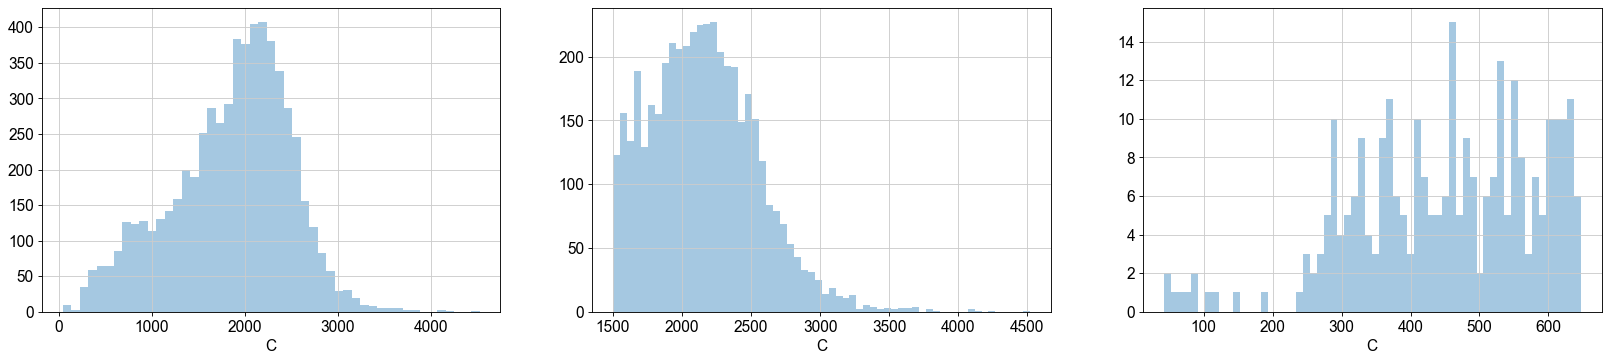

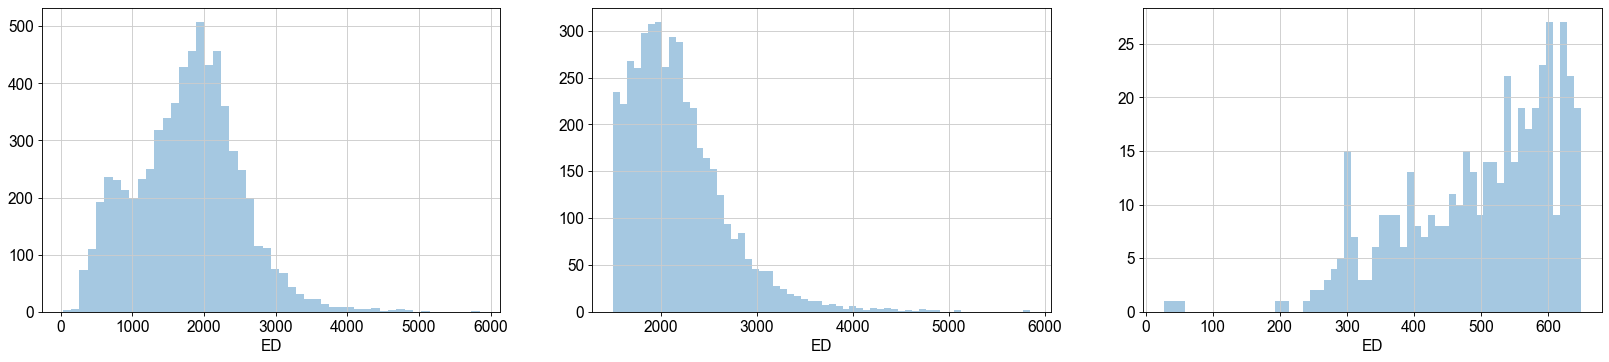

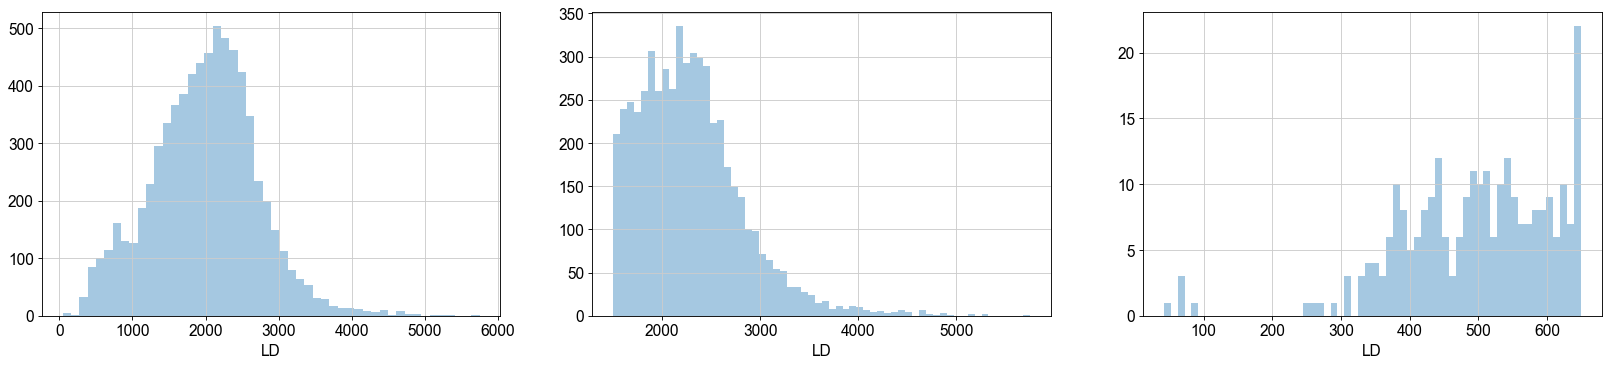

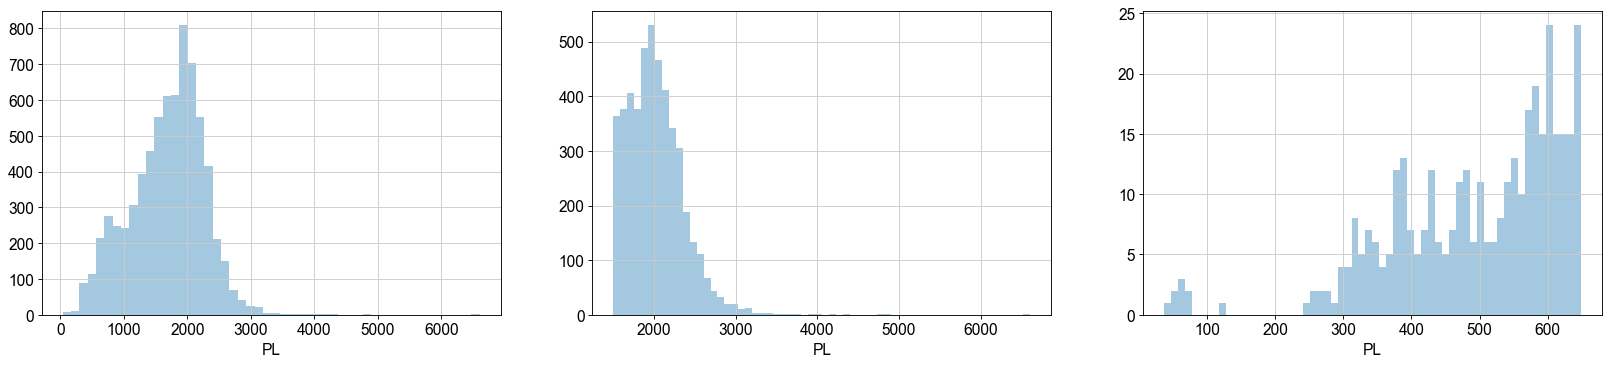

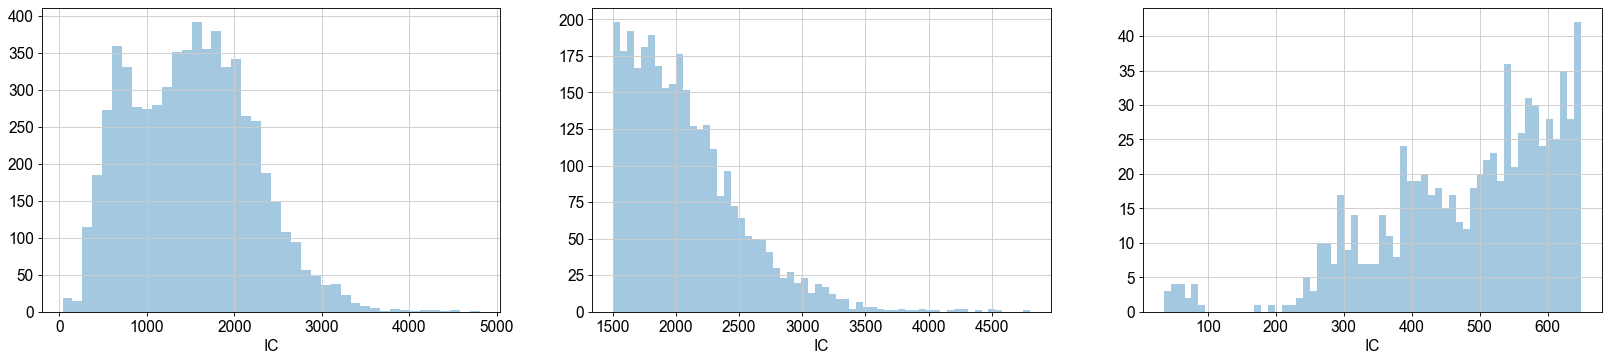

In [21]:
#Thresholding decision: genes
for file in list(range(0, conditionlength)):
    fig,ax = plt.subplots(1,3, figsize=(25,5))
    p8 = sb.distplot(adata[file].obs['n_genes'], axlabel = conditionnames[file], kde=False,ax=ax[0])
    p6 = sb.distplot(adata[file].obs['n_genes'][adata[file].obs['n_genes']>1500], axlabel = conditionnames[file], kde=False, bins=60,ax=ax[1])
    p7 = sb.distplot(adata[file].obs['n_genes'][adata[file].obs['n_genes']<650], axlabel = conditionnames[file], kde=False, bins=60,ax=ax[2])
    time.sleep(1)


### 2.2.2 Filtering
Filtering parameters are set in one of the first cells of this notebook for convenience

In [22]:
for file in list(range(0, conditionlength)):
    print(conditionnames[file])
    print(conditionnames[file],'Cells before filtering: {0}'.format(adata[file].shape[0]))
    sc.pp.filter_cells(adata[file], max_counts = max_n_counts[file])
    print('Number of cells after max count filter: {0}'.format(adata[file].shape[0]))

    adata[file] = adata[file][adata[file].obs['percent_mito'] < max_mito[file]]
    print('Number of cells after mitochondrial gene percentage filter: {0}'.format(adata[file].shape[0]))

    sc.pp.filter_cells(adata[file], min_genes = min_n_genes[file])
    print('Number of cells after min gene filter: {0}'.format(adata[file].shape[0]))

    print('Cells after filtering: {0}'.format(adata[file].shape[0]))
    
    # a threshold for maximum genes can be established
    #sc.pp.filter_cells(adata, max_genes = 5000)
    time.sleep(1)

filtered out 10 cells that have more than 15000 counts
filtered out 58 cells that have less than 550 genes expressed
Trying to set attribute `.obs` of view, copying.


C
C Cells before filtering: 6082
Number of cells after max count filter: 6072
Number of cells after mitochondrial gene percentage filter: 5787
Number of cells after min gene filter: 5729
Cells after filtering: 5729


filtered out 28 cells that have more than 18000 counts


ED
ED Cells before filtering: 6702
Number of cells after max count filter: 6674
Number of cells after mitochondrial gene percentage filter: 6403


filtered out 162 cells that have less than 550 genes expressed
Trying to set attribute `.obs` of view, copying.


Number of cells after min gene filter: 6241
Cells after filtering: 6241


filtered out 70 cells that have more than 18000 counts


LD
LD Cells before filtering: 7146
Number of cells after max count filter: 7076
Number of cells after mitochondrial gene percentage filter: 6844


filtered out 60 cells that have less than 500 genes expressed
Trying to set attribute `.obs` of view, copying.


Number of cells after min gene filter: 6784
Cells after filtering: 6784


filtered out 14 cells that have more than 15000 counts


PL
PL Cells before filtering: 7170


filtered out 129 cells that have less than 550 genes expressed
Trying to set attribute `.obs` of view, copying.


Number of cells after max count filter: 7156
Number of cells after mitochondrial gene percentage filter: 6998
Number of cells after min gene filter: 6869
Cells after filtering: 6869


filtered out 24 cells that have more than 14000 counts


IC
IC Cells before filtering: 6230


filtered out 316 cells that have less than 550 genes expressed
Trying to set attribute `.obs` of view, copying.


Number of cells after max count filter: 6206
Number of cells after mitochondrial gene percentage filter: 5857
Number of cells after min gene filter: 5541
Cells after filtering: 5541


In [23]:
for file in list(range(0, conditionlength)):
    print(conditionnames[file])
    #Filter genes:
    print('Total number of genes: {:d}'.format(adata[file].n_vars))
    sc.pp.filter_genes(adata[file], min_cells=filter_genes) 
    print('Number of genes after cell filter: {:d}'.format(adata[file].n_vars))
    time.sleep(1)

filtered out 15533 genes that are detected in less than 3 cells


C
Total number of genes: 31251
Number of genes after cell filter: 15718
ED
Total number of genes: 31251


filtered out 15166 genes that are detected in less than 3 cells


Number of genes after cell filter: 16085


filtered out 14966 genes that are detected in less than 3 cells


LD
Total number of genes: 31251
Number of genes after cell filter: 16285


filtered out 15477 genes that are detected in less than 3 cells


PL
Total number of genes: 31251
Number of genes after cell filter: 15774


filtered out 15304 genes that are detected in less than 3 cells


IC
Total number of genes: 31251
Number of genes after cell filter: 15947


## Merging data and saving

In [24]:
## If you wish to save datasets individually without merging, BEFORE merging:
#for file in list(range(0, conditionlength)):
 #   filtered_file = 'outputs/' + tissue + '/terva_'+ tissue + '-' + conditionnames[file] + '-qc.h5ad'
 #   adata[file].write(filtered_file)
## Loading would then be done as:
#adata=[sc.read('outputs/'+ tissue + '/terva_' + tissue + '-' + name + '-qc_filtered_with_doublets.h5ad', cache=False) for name in conditionnames]

In [25]:
#merge and save data
adata_merge=adata[0].concatenate(adata[1:])
del adata_merge.obs['batch'] #remove automatically created variable 'batch' obs (redundant because of ConditionID)
adata_merge.write(filtered_file)

... storing 'ConditionName' as categorical
... storing 'celltype_pred_0' as categorical


In [26]:
## If you wish to save datasets individually AFTER merging:
adata = adata_merge
del(adata_merge)

for file in list(range(0, conditionlength)):  
    filtered_file = 'outputs/' + tissue + '/terva_'+ tissue + '-' + conditionnames[file] + '-qc_DSB.h5ad'
    adata[adata.obs['ConditionName'] == conditionnames[file]].write(filtered_file)